# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --quiet bertopic datasets hdbscan flash-attn torch accelerate requests pyarrow==15.0.0 scipy==1.11.4 kaleido

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from umap import UMAP
import re
from datasets import load_dataset
from bertopic import BERTopic
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch
from bertopic.dimensionality import BaseDimensionalityReduction
import pandas as pd
from bertopic.representation import TextGeneration
from bertopic import BERTopic
from sklearn.cluster import KMeans
from bertopic.vectorizers import ClassTfidfTransformer
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)  # None means no limit

# Load masked en preprocessed dataset

In [ ]:
dataset = load_dataset('json', data_files='/path/to/datafiles.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
comments = []
discussions = []
opening_posts = []
for example in dataset['COMMENTS']:
    comment_texts = [comment['TEXT-MASKED'] for comment in example]
    comments.extend(comment_texts)
    discussions.append(" ".join(comment_texts))
    opening_posts.append(example[0]['TEXT-MASKED'])

# Create UMAP embeddings

In [ ]:
embedding_path = '/path/to/embddings/folder/'

In [ ]:
# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

#### Comments

In [ ]:
# Generate embeddings
embeddings_comments = model.encode(comments, batch_size=32, show_progress_bar=True)

# Dimensionality reduction using UMAP, using BERTopic default parameters
umap_model_comments = UMAP(n_neighbors=15, n_components=5, metric='cosine')
umap_embeddings_comments = umap_model_comments.fit_transform(embeddings_comments)

# Save the UMAP embeddings to a file
np.save(embedding_path+'umap_embeddings_comments.npy', umap_embeddings_comments)

Batches:   0%|          | 0/8816 [00:00<?, ?it/s]

#### Discussions

In [ ]:
# Generate embeddings
embeddings_discussions = model.encode(discussions, batch_size=32, show_progress_bar=True)

# Dimensionality reduction using UMAP, using BERTopic default parameters
umap_model_discussions = UMAP(n_neighbors=15, n_components=5, metric='cosine')
umap_embeddings_discussions = umap_model_discussions.fit_transform(embeddings_discussions)

# Save the UMAP embeddings to a file
np.save(embedding_path+'umap_embeddings_discussions.npy', umap_embeddings_discussions)

Batches:   0%|          | 0/1591 [00:00<?, ?it/s]

#### Opening posts

In [ ]:
# Generate embeddings
embeddings_opening_posts = model.encode(opening_posts, batch_size=32, show_progress_bar=True)

# Dimensionality reduction using UMAP, using BERTopic default parameters
umap_model_opening_posts = UMAP(n_neighbors=15, n_components=5, metric='cosine')
umap_embeddings_opening_posts = umap_model_opening_posts.fit_transform(embeddings_opening_posts)

# Save the UMAP embeddings to a file
np.save(embedding_path+'umap_embeddings_opening_posts.npy', umap_embeddings_opening_posts)

Batches:   0%|          | 0/1591 [00:00<?, ?it/s]

# Load UMAP embeddings

In [ ]:
embedding_path = '/path/to/embddings/folder/'

In [ ]:
umap_embeddings_comments = np.load(embedding_path+'umap_embeddings_comments.npy')
umap_embeddings_discussions = np.load(embedding_path+'umap_embeddings_discussions.npy')
umap_embeddings_opening_posts = np.load(embedding_path+'umap_embeddings_opening_posts.npy')

# Clustering

#### Uncomment the group of texts you want to process:

In [ ]:
documents = discussions
umap_embeddings = umap_embeddings_discussions
document_type = 'discussions'

# documents = comments
# umap_embeddings = umap_embeddings_comments
# document_type = 'comments'

# documents = opening_posts
# umap_embeddings = umap_embeddings_opening_posts
# document_type = 'discussion opening posts'

In [ ]:
# Load the default English stop words
default_stop_words = CountVectorizer(stop_words='english').get_stop_words()

# Add your custom stop word(s)
custom_stop_words = list(default_stop_words) + ['mask']

# Initialize the CountVectorizer with the custom stop words
vectorizer_model = CountVectorizer(stop_words=custom_stop_words)

# Initialze 'empty' dimensionality model, as the embeddings have already been reduced
empty_dimensionality_model = BaseDimensionalityReduction()

In [ ]:
# Load Phi-3 model and tokenizer for labeling
model_name = 'microsoft/Phi-3-mini-128k-instruct'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="cuda",
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
        trust_remote_code=True,

    )
labeler = pipeline('text-generation', model=model, tokenizer=tokenizer, return_full_text=False, max_new_tokens=50)

In [ ]:
def generate_prompt(document_type):
    return (
        "<|user|>"
        f"Objective: Provide a concise and descriptive label for a cluster of {document_type} based on the given keywords.\n\n"
        "This cluster is described by the following keywords: [KEYWORDS]\n\n"
        "Based on the provided keywords, please generate a concise and descriptive label for this cluster. "
        "The label should accurately represent the main theme or topic of the cluster.\n\n"
        "Please respond with only the label.\n\n"
        "---\n\n"
        "Expected Output:\n"
        f"Label: [short, descriptive label that captures the essence of the {document_type} and keywords]"
        "<|end|><|assistant|>"
    )

# Create representation model
phi_label = TextGeneration(labeler, prompt=generate_prompt(document_type))
representation_model = {
    "phi_label": phi_label,
}

### KMeans

#### Elbow method to determine K

In [ ]:
inertia = []
cluster_range = range(5, 50, 5)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(umap_embeddings)
    inertia.append(kmeans.inertia_)

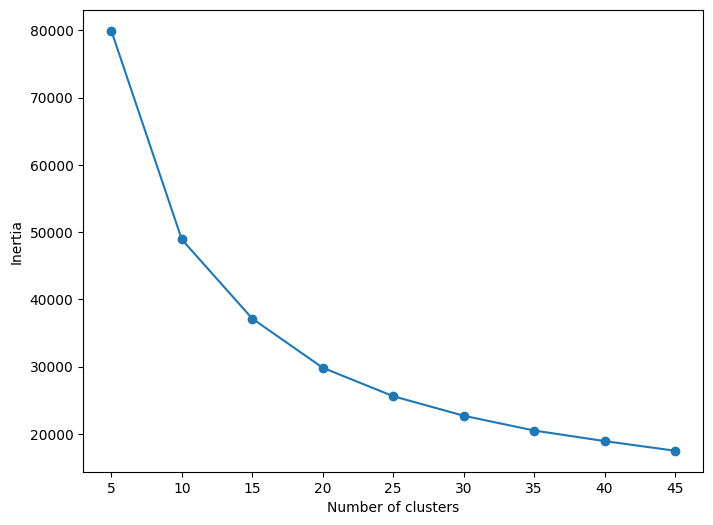

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Run BERTopic

In [ ]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True) # Reduce frequent words from the representing keywords

cluster_model = KMeans(n_clusters=15, random_state=42)
topic_model = BERTopic(hdbscan_model=cluster_model,
                                vectorizer_model=vectorizer_model,
                                umap_model=empty_dimensionality_model,  # Use empty model as embeddings are already reduced
                                verbose=True,
                                ctfidf_model=ctfidf_model,
                                representation_model=representation_model
                       )

In [ ]:
topics, probs = topic_model.fit_transform(documents, embeddings=umap_embeddings)

2024-08-15 08:37:25,244 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-08-15 08:37:25,245 - BERTopic - Dimensionality - Completed ✓
2024-08-15 08:37:25,248 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-08-15 08:37:26,097 - BERTopic - Cluster - Completed ✓
2024-08-15 08:37:26,109 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 15/15 [00:11<00:00,  1.25it/s]
2024-08-15 08:37:40,503 - BERTopic - Representation - Completed ✓


##### Topic info

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,phi_label,Representative_Docs
0,0,6525,0_references_sources_content_reliability,"[references, sources, content, reliability, ci...",[ Label: Wikipedia Content Reliability and Cit...,[The need for better references for the inform...
1,1,5626,1_claim_regarding_accuracy_post,"[claim, regarding, accuracy, post, verifying, ...",[ Label: Verifying Historical Claims on Wikipe...,[Verifying [MASK] accuracy of [MASK] informati...
2,2,4864,2_term_definition_context_classification,"[term, definition, context, classification, po...",[ Label: Clarifying Terminology in Historical ...,[The accuracy of the information provided in t...
3,3,4424,3_claim_post_context_historical,"[claim, post, context, historical, opening, fo...",[ Label: Historical Debates on Religious Repre...,[The accuracy of the current content in the Wi...
4,4,4218,4_claim_verifying_regarding_seeking,"[claim, verifying, regarding, seeking, questio...",[ Label: Verification of Information and Claim...,[The accuracy and truthfulness of the informat...
5,5,3622,5_removal_edit_edits_deletion,"[removal, edit, edits, deletion, removed, edit...",[ Label: Wikipedia Editing Controversies and U...,[The removal of references from the Wikipedia ...
6,6,3387,6_content_sources_wikipedia_notability,"[content, sources, wikipedia, notability, wiki...",[ Label: Wikipedia Content and Notability Poli...,[Concerns regarding the neutrality of the arti...
7,7,3299,7_section_content_view_contributor,"[section, content, view, contributor, lead, ar...",[ Label: Neutrality and Bias in Wikipedia Cont...,"[Recent edits to a Wikipedia article, specific..."
8,8,2785,8_map_location_nationality_historical,"[map, location, nationality, historical, geogr...",[ Label: British Ancestry and Citizenship Veri...,[The accuracy and relevance of the information...
9,9,2779,9_number_figure_figures_numbers,"[number, figure, figures, numbers, data, discr...",[ Label: Data Discrepancy and Accuracy in Repo...,[[MASK] accuracy of [MASK] [MASK] numbers of [...


##### Intertopic Distance Map

In [ ]:
fig = topic_model.visualize_topics()
fig.show()
fig.write_html(f"intertopic_distance_plot_{document_type}.html")

##### Hierarchical Clustering graph

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
fig_hier = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig_hier.show()
fig_hier.write_html(f'hierarchical_topics_visualization_{document_type}.html')

100%|██████████| 14/14 [00:00<00:00, 119.58it/s]


In [ ]:
# Get topic information
topic_info = topic_model.get_topic_info()

# Extracting the top 10 keywords for each topic
def get_top_keywords(topic_num):
    keywords = topic_model.get_topic(topic_num)
    top_keywords = [keyword for keyword, _ in keywords[:10]]
    return ", ".join(top_keywords)

# Adding the top 10 keywords to the topic information
topic_info['Top 10 Keywords'] = topic_info['Topic'].apply(get_top_keywords)
topic_info['Phi-label'] = topic_info['phi_label'].apply(lambda x: x[0])

# Creating a table with Topic number, document count, and top 10 keywords
topic_table = topic_info[['Phi-label', 'Top 10 Keywords', 'Count']]

In [ ]:
topic_table